<h1>Feature Engineering</h1>


In [744]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import LineCollection

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


----
<p>I will generate 150 points for the training set. Points on or below the axis will be blue. Points above the axis will be red.</p>

----

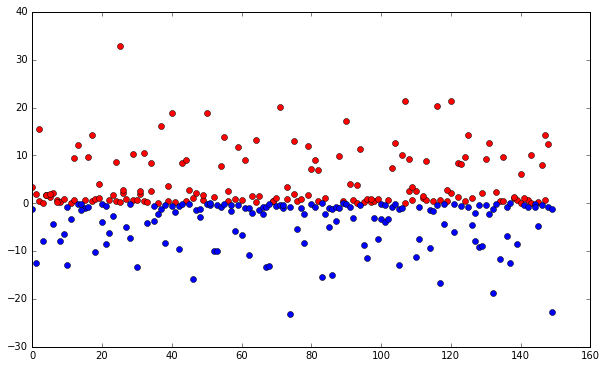

In [730]:
mean   = [0, 0]
cov    = [[1, 0], [0, 100]]
points = np.random.multivariate_normal(mean, cov, 150)
points = np.round(points, decimals = 2)

pos_points = points.copy()
neg_points = points.copy()

pos_points[pos_points <= 0] = np.nan
neg_points[neg_points >  0] = np.nan

plt.plot(pos_points, 'ro', color = 'r')
plt.plot(neg_points, 'ro', color = 'b',)

----
<p>Having visually generated the concept, I will now provide labels for all of the training points.</p>
<p>This means that everything above 0.5 wil have the label <code>0</code> and everything equal to or below 0.5, the label <code>1</code>.</p>
<p>I will create a dataframe which has three columns. Column one and two will be the (x,y) coordinates, and the third column will be the label.</p>

----

In [731]:
pointsDF = pd.DataFrame(points)

scaled = MinMaxScaler(feature_range=(0,1))
pointsDF = scaled.fit_transform(pointsDF)

pointsDF = pd.DataFrame(pointsDF)

In [732]:
pointsDF['label'] = np.where((pointsDF[1] <= 0.5), 2, 1)

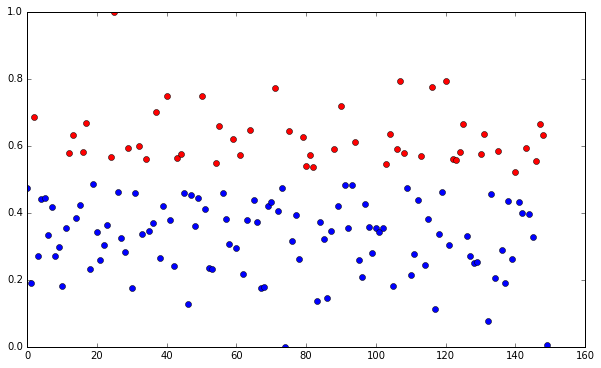

In [733]:
zeros = pointsDF[(pointsDF.label==1)]
ones  = pointsDF[(pointsDF.label==2)]


plt.plot(zeros[1], 'ro', color='r' )
plt.plot(ones[1],  'ro', color='b' )

----

<h3>I have simplified the problem.</h3>
<p>Now there is just one variable, apart from the <code>index</code> and the <code>label</code>. So for instance <code>point 120</code> or <code>point 3</code> or <code>point 43</code> and its correponding value, which takes on a number between <code>0</code> and <code>1</code>. If it is below <code>0.5</code> it takes on the <code>label 1</code> and if it is above <code>0.5</code> it takes on the <code>value 0</code>.</p>

----


<h3>Split into train and test sets, with seperate refs for each column</h3>

In [755]:
trainX = pointsDF.iloc[0:100,0:2]
#testX  = pointsDF.iloc[101:, 1]

trainY = pointsDF.iloc[0:100,2]
#testY  = pointsDF.iloc[101:, 2]

print(len(trainX), len(trainY))

100 100


In [756]:
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)

In [757]:
print(trainX)

[[ 0.16840278  0.47449162]
 [ 0.72569444  0.19033179]
 [ 0.46354167  0.68765608]
 [ 0.40451389  0.27042455]
 [ 0.68402778  0.44166964]
 [ 0.61458333  0.44541563]
 [ 0.77777778  0.33410631]
 [ 0.51736111  0.41776668]
 [ 0.42361111  0.27238673]
 [ 0.53645833  0.29932215]
 [ 0.25173611  0.18034249]
 [ 0.39930556  0.35354977]
 [ 0.50173611  0.579736  ]
 [ 0.36111111  0.63128791]
 [ 0.37847222  0.38530146]
 [ 0.22743056  0.42383161]
 [ 0.24652778  0.58294684]
 [ 0.48090278  0.66856939]
 [ 0.55381944  0.2318944 ]
 [ 0.56423611  0.48590796]
 [ 0.34548611  0.34338209]
 [ 0.28645833  0.26043525]
 [ 0.50694444  0.30288976]
 [ 0.67534722  0.36443097]
 [ 0.47222222  0.56617909]
 [ 0.43402778  1.        ]
 [ 0.77604167  0.46271852]
 [ 0.55208333  0.32554406]
 [ 0.375       0.28433821]
 [ 0.51215278  0.59489832]
 [ 0.515625    0.17606136]
 [ 0.71180556  0.45843739]
 [ 0.45486111  0.59900107]
 [ 0.44791667  0.33713878]
 [ 0.81770833  0.56207635]
 [ 0.30555556  0.34659294]
 [ 0.40972222  0.3704959 ]
 

In [758]:
print(trainY)

[2 2 1 2 2 2 2 2 2 2 2 2 1 1 2 2 1 1 2 2 2 2 2 2 1 1 2 2 2 1 2 2 1 2 1 2 2
 1 2 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 1 1 2 2 2 1 2 1 2 2 1 2 2 2 2 2 2 1 2 2
 2 1 2 2 2 1 1 1 1 2 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 2]


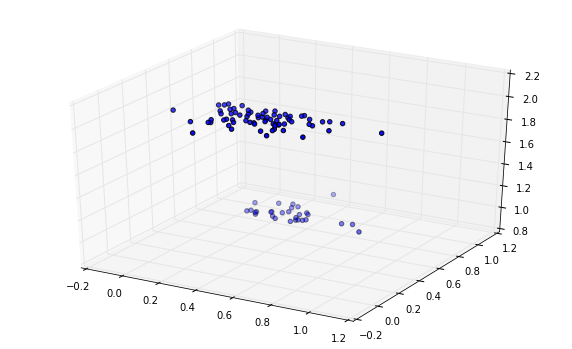

In [770]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(pointsDF.iloc[0:100,0], pointsDF.iloc[0:100,1], pointsDF.iloc[0:100,2])


<h3>Time to build the net...</h3>

In [759]:
import math
import tensorflow as tf

----

<h3>Below</h3>

<p>is a simpler implementation of a classification algorithm</p>

----

In [771]:
learning_rate   = 0.001
training_epochs = 20
batch_size      = 100
display_step    = 1

n_hidden_1 = 256
n_hidden_2 = 256
n_input    = 1
n_classes  = 1

X = tf.placeholder("float")
Y = tf.placeholder("float")

#trainX = tf.convert_to_tensor(trainX)
#trainY = tf.convert_to_tensor(trainY)

In [772]:
def multilayer_perceptron(X, weights, biases):
    layer_1 = tf.add(tf.matmul( X, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b1'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    
    return out_layer

In [773]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred      = multilayer_perceptron(X, weights, biases)
cost      = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init      = tf.initialize_all_variables()

In [775]:
with tf.Session() as sess:
    
    sess.run(init)
        
    for epoch in range(training_epochs):
        #avg_cost = 0.
        
        for (xs, ys) in zip(trainX, trainY):
            print(xs, ys)
            print(X, Y)
            print(optimizer)
            sess.run(optimizer, feed_dict={X:xs, Y:ys})
            
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={xs: trainX, ys: trainY})
    
    print("op finished")
    training_cost = sess.run(cost, feed_dict={x:trainX, y:trainY})
    print(training_cost)

[ 0.16840278  0.47449162] 2
Tensor("Placeholder_157:0", dtype=float32) Tensor("Placeholder_158:0", dtype=float32)
name: "Adam_40"
op: "NoOp"
input: "^Adam_40/update_Variable_475/ApplyAdam"
input: "^Adam_40/update_Variable_476/ApplyAdam"
input: "^Adam_40/update_Variable_477/ApplyAdam"
input: "^Adam_40/update_Variable_478/ApplyAdam"
input: "^Adam_40/update_Variable_480/ApplyAdam"
input: "^Adam_40/Assign"
input: "^Adam_40/Assign_1"



InvalidArgumentError: Expected begin[0] == 0 (got -1) and size[0] == 0 (got 1) when input.dim_size(0) == 0
	 [[Node: Slice_129 = Slice[Index=DT_INT32, T=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](Shape_131, Slice_129/begin, Slice_129/size)]]

Caused by op 'Slice_129', defined at:
  File "//anaconda/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "//anaconda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "//anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "//anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-773-bd3cd6ede2f9>", line 14, in <module>
    cost      = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, Y))
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 670, in softmax_cross_entropy_with_logits
    labels = _flatten_outer_dims(labels)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 472, in _flatten_outer_dims
    array_ops.shape(logits), [math_ops.sub(rank, 1)], [1])
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 431, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2234, in _slice
    name=name)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Expected begin[0] == 0 (got -1) and size[0] == 0 (got 1) when input.dim_size(0) == 0
	 [[Node: Slice_129 = Slice[Index=DT_INT32, T=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](Shape_131, Slice_129/begin, Slice_129/size)]]


----

<h3>Building a graph function</h3>

<p>It will color each point depending on whether the preceeding point is higher or lower than the given point.</p>

----

<h4>Here is our data</h4>

In [147]:
datapoints = np.linspace(0,30, num=30, endpoint=False)
noisy_datapoints = np.random.randint(4, size=30) + datapoints

30


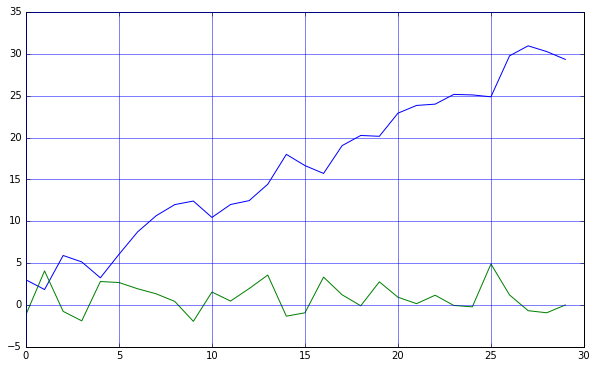

In [148]:
sinCurve       = np.sin(datapoints) + noisy_datapoints
sinCurve_grad  = np.gradient(sinCurve, 1)
# finding the second order derivative is unnecessary: sinCurve_twograd = np.gradient(sinCurve_grad)
#instead of using the gradient, I plan to use the difference between each consecutive point. Is it neg or pos?

sinCurve_diff  = np.diff(sinCurve)

sinCurve_diff = np.insert(sinCurve_diff, 29, 0)
print(len(sinCurve_diff))

sinCurve_diff = pd.Series(sinCurve_diff)

sinCurve_pn = np.where((sinCurve_diff < 0), 'r', 'b')

fig = plt.figure()
ax = fig.gca()
#ax.set_xticks(numpy.arange(0,1,0.1))
#ax.set_yticks(numpy.arange(0,1.,0.1))
    
plt.plot(sinCurve)
plt.plot(sinCurve_diff)

grid(b=True, which='major', color='b', linestyle='-')
grid(b=True, which='minor', color='r', linestyle='--')

<h4>And now for the colouring function in pseudocode:</h4>
<p><code>for eachPoint <i>between</i> Point_2 <i>and<i> Point_n:</code></p>
<p><code>    if [eachPoint - 1] > eachPoint:</code></p>
<p><code>        turn eachPoint red</code></p>
<p><code>    elif [eachPoint - 1] < eachPoint:</code></p>
<p><code>        turn eachPoint blue</code></p>
<p><code>    else:</code></p>
<p><code>        turn eachPoint grey</code></p>

In [149]:
sinCurveDF = pd.DataFrame({'sinCurve': sinCurve, 'diff':sinCurve_diff, 'pn':sinCurve_pn})

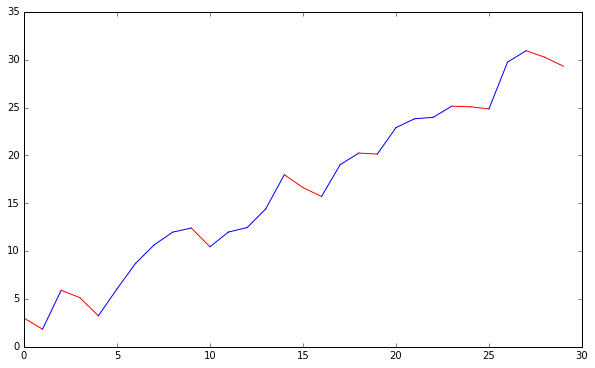

In [150]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
for s in range(0, len(sinCurveDF.sinCurve) - 1):
    x=(sinCurveDF.index[s], sinCurveDF.index[s + 1])
    y=(sinCurveDF.sinCurve[s], sinCurveDF.sinCurve[s + 1])
    ax.plot(x, y, c=sinCurveDF.pn[s])
plt.show()